# -1) Import des données

In [72]:
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
dataset = pd.read_csv(filepath_or_buffer="/Users/anir/Documents/household_power_consumption/household_power_consumption.csv"
                      ,sep=";", low_memory=False)
print("dimensions du dataset : ", dataset.shape)

dimensions du dataset :  (2075259, 9)


In [73]:
dataset.head()
# a brief view of the dataframe

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [60]:
dataset.info()
### next step is to affect the good type for each input variable

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 10 columns):
Date                     object
Time                     object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Sub_metering_4           float64
dtypes: float64(8), object(2)
memory usage: 172.0+ MB


# 0) descriptif des données

* 2075259 lignes
* mesure de la consommation electrique d'une maison sur une 
* periode d'enregistrement 47 mois - dec 2006-nov 2010 -
* 1 lignes correspond à une mesure toutes les minutes 

### Les variables du dataset : 

* **full_date**: Date in format dd/mm/yyyy hh:mm:ss 

* **global_active_power**: household global minute-averaged active power (in kilowatt) **kw/min**

* **global_reactive_power**: household global minute-averaged reactive power (in kilowatt) **kw/min**

* **voltage**: tension en **volt**

* **global_intensity**: intensité globale de la maison **ampere**

* **sub_metering_1**: mesure en energie active la consomation de la cuisine, impliquant un lave-vaisselle, un four et un micro onde. **Watt/hour**

* **sub_metering_2**: mesure de la conso en energie active de laverie, ou se trouve une machine a laver ainsi qu'un seche linge, un frigidaire et une lampe. **Watt/hour**

* **sub_metering_3**: mesure de la conso d'un chauffe-eau ainsi qu'un climatiseur. **Watt/hour**

* **sub_metering_4**: mesure de la conso du reste des autres elements de la maison non mentionnés dans les sub_metering.

### La problematique metier : 

En s'appuyant sur ce jeu de données, nous pouvons ajuster des modeles qui nous permetterait d'anticiper la consommation d'energie pour une seule et unique maison. Si ce modele reussi à bien predire cette consommation, celui ci pourrait être reutilisé à echelle industrielle dans le cadre suivant .

Si chaque set de mesure de consommation pour chaque maison permet d'ajuster un modele pour une maison ou alors pour un ensemble de maison, alors on pourra ajuster au mieux la production de l'energie électrique et ainsi economiser des ressource car le plus gros problème dans l'energie éléctrique, est la difficulté de stocker celle ci. 

Ce notebook est composé de 3 parties : 
    
Dans un premier temps faire une decouverte des données puis ajuster deux modele de predictions de nature differente.

 ##### 1) Decouverte des données
 
 
 ##### 2) Analyse de la serie temporelle & ajustement ARIMA
 
 
 ##### 3) Modele de prediction LSTM

In [74]:
"""Ci dessus, je transforme tout mes vecteurs qui ont été typés objets en type numerique."""

for col in ["Global_active_power", "Global_reactive_power",
            "Voltage","Global_intensity","Sub_metering_1","Sub_metering_3","Sub_metering_2"]:
    dataset[col] = pd.to_numeric(dataset[col], errors="coerce")

In [75]:
"""transforme la variable "gloabl_ative_power" en Wh"""

dataset["Global_active_power"] = dataset["Global_active_power"]*1000/60 #transforming

In [76]:
"""creation de la variable sub_metering_4"""

dataset["Sub_metering_4"] =( (dataset["Global_active_power"]) 
                            - dataset["Sub_metering_1"]-dataset["Sub_metering_2"]-dataset["Sub_metering_3"])

In [77]:
"""
creation d'une colonne full_date pour y faire figurer la date + l'heure dans un format datetime
dans le but de pouvoir y appliquer eventuellement des time series sur le dataset.
"""
dataset["full_date"] = pd.to_datetime(dataset["Date"]+" "+dataset["Time"], format="%d/%m/%Y %H:%M:%S")
del dataset["Date"]
del dataset["Time"]

In [78]:
dataset["Month"] = dataset["full_date"].apply(lambda x: x.month)
dataset["Hour"] = dataset["full_date"].apply(lambda x: x.hour)
dataset["Minute"] = dataset["full_date"].apply(lambda x: x.minute)
dataset["Week"] = dataset["full_date"].apply(lambda x: x.week)
dataset["Year"] = dataset["full_date"].apply(lambda x: x.year)
dataset["Day"] = dataset["full_date"].apply(lambda x: x.weekday())

""" les operations sur les dates sont chronophages """

' les operations sur les dates sont chronophages '

In [79]:
""" suppression des valeurs nulles """
dataset = dataset.dropna(axis=0)

In [80]:
""" parametrage de l'affichage des plot """
plt.rcParams["figure.figsize"] = (20,8)

# 1) Decouverte des données 

### Indicateurs de consommation d'energie active moyenne pour chaque mois de l'année

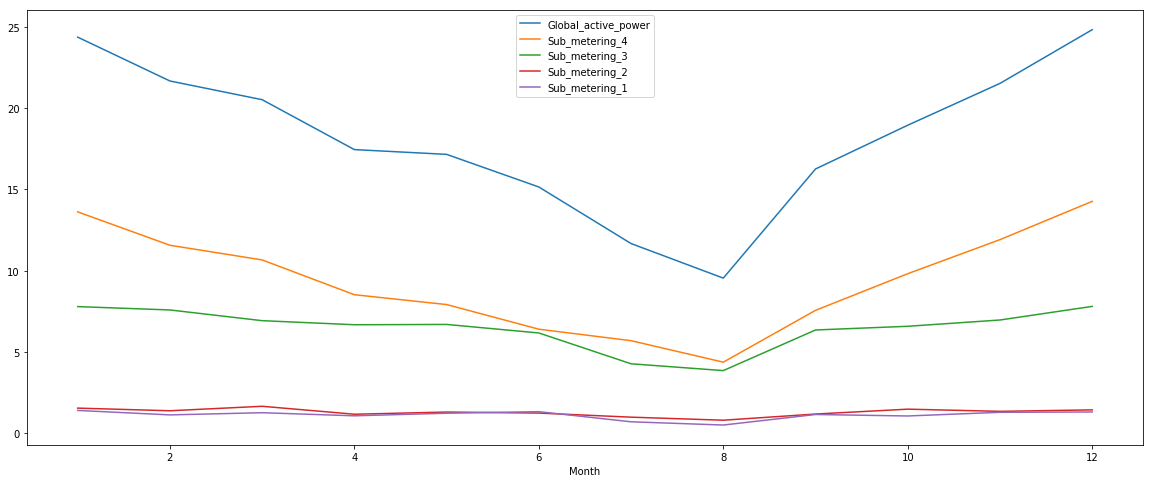

In [81]:
month_sample = dataset.groupby(["Month"]).mean()
month_sample[["Global_active_power","Sub_metering_4","Sub_metering_3","Sub_metering_2", "Sub_metering_1"]].plot(kind="line")

On peut discerner un creux remarquable en Aout (8)  

### Indicateurs de consommation d'energie active moyenne pour chaque semaine de l'année 

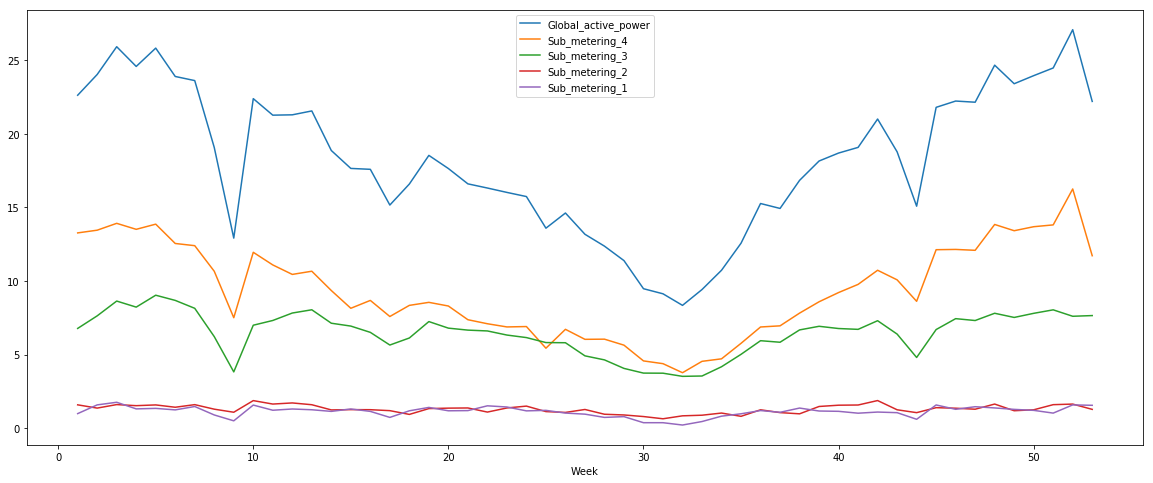

In [83]:
week_sample = dataset.groupby(["Week"]).mean()
week_sample[["Global_active_power","Sub_metering_4","Sub_metering_3","Sub_metering_2", "Sub_metering_1"]].plot(kind="line")

Sur ce graphe on peut observer a peu près les mêmes patterns que le precedent, au detail prés qu'on voit certains creux qui correspondent probablement à des semaines de vacances.

### Indicateurs de consommation d'energie active moyenne pour chaque jour de la semaine

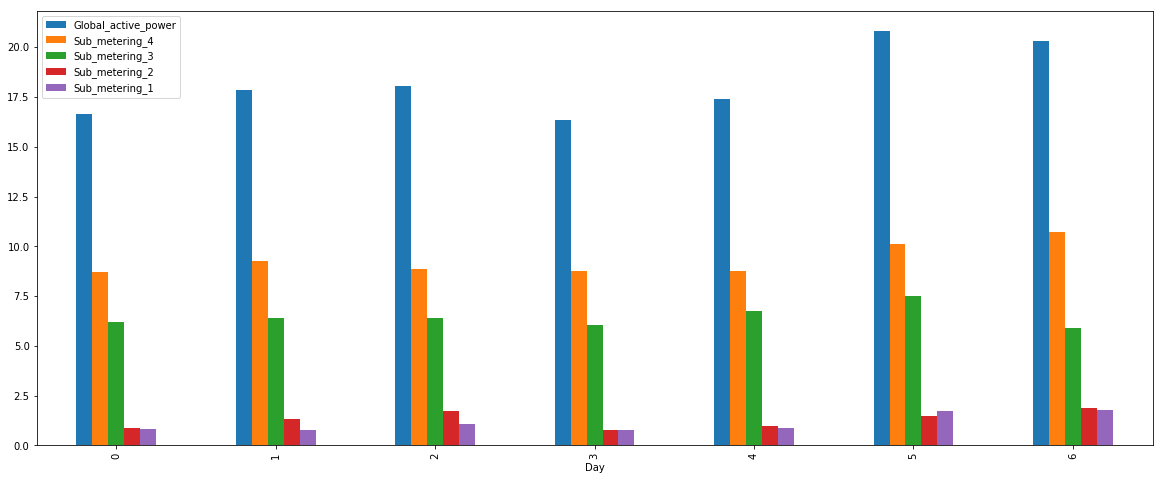

In [82]:
day_sample = dataset.groupby(["Day"]).mean()
day_sample[["Global_active_power","Sub_metering_4","Sub_metering_3","Sub_metering_2", "Sub_metering_1"]].plot(kind="bar")

On peut voir sur ce graphe que le climatiseur ainsi que le chauffe eau (sub_metering_3) representent environ 35% de la consommation journaliere moyenne

### Indicateurs de consommation d'energie active moyenne pour chaque heure de la journée

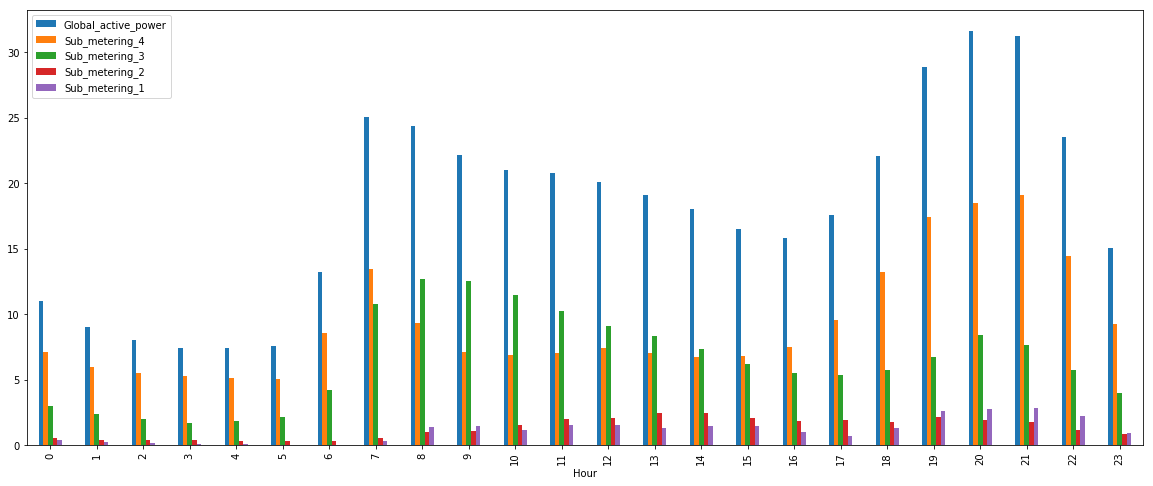

In [84]:
hour_sample = dataset.groupby(["Hour"]).mean()
hour_sample[["Global_active_power","Sub_metering_4","Sub_metering_3","Sub_metering_2", "Sub_metering_1"]].plot(kind="bar")

On peut noter une forte activité autour de 20h et de  7h du matin.

### Indicateurs de consommation d'energie active moyenne chaque jour

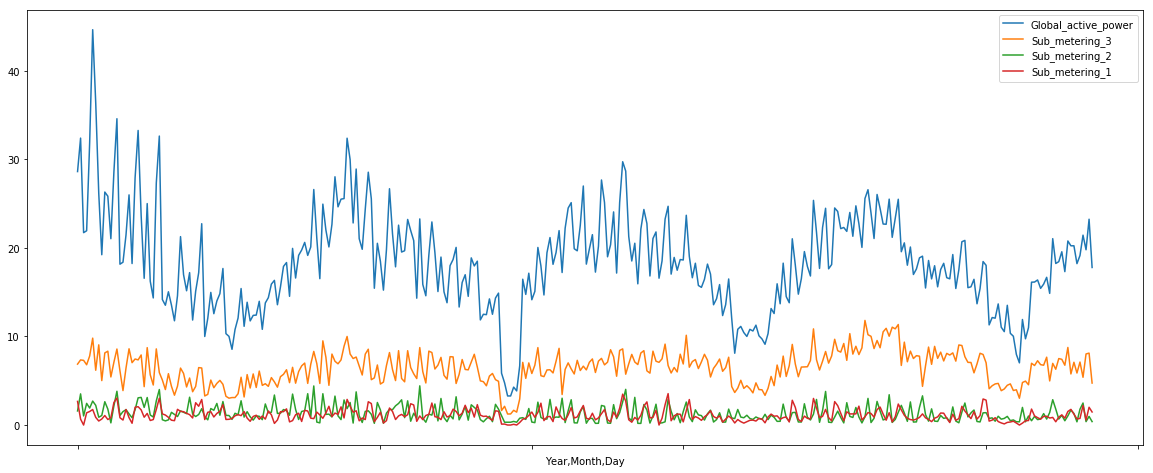

In [88]:
resample = dataset.groupby(["Year","Month","Day"]).mean()
resample[["Global_active_power","Sub_metering_3","Sub_metering_2", "Sub_metering_1"]].plot(kind="line")

En observant la courbe globale active power, on peut soupconner qu'il y a eventuellement une repetition de son pattern au cours des années, nous pouvons alors faire une premiere tentative de réalisation de modele chronologique en s'appuyant sur les series temporelles. 
Je vais dans un premier temps simplement ajuster un ARIMA en considerant simplement le temps (analyse temporelle univariée).
Je vais m'appuyer sur le dataset qui represente simplement une moyenne d'energie active par jour pour reduire le nombre d'entrées car l'ajustement des modeles temporels sont très chronophages.

# 2) Analyse de la serie temporelle & ajustement ARIMA

Pour commencer, il faut tout d'abord verifier la stationarité de la serie, l'absence d'une tendance et de la saisonnalité. 


In [93]:
"""creation de l'objet timeseries de pandas."""
ts = pd.Series(dataset['Global_active_power'].values, index=dataset['full_date'])

In [94]:
"""resampling selon les jours"""
ts = ts.resample("D").sum()

### Aperçu de la serie temporelle

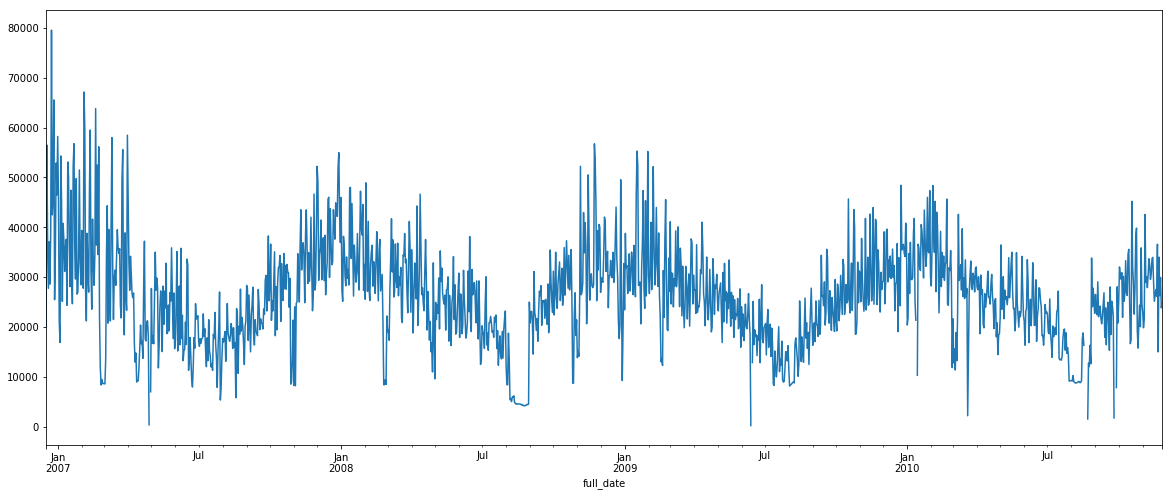

In [20]:
ts.plot()

La serie ne semble pas presenter de tendance ni de saisonnalité evidente, nous allons admettre ces deux conditions puis nous passons au test de stationnarité dickey-fuller ou test de racine unitaire de Dickey-Fuller. Un test statistique qui vise à savoir si une série temporelle est stationnaire c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varient ou pas dans le temps.

In [95]:
"""test de stationnarité"""
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
  
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()
  import sys


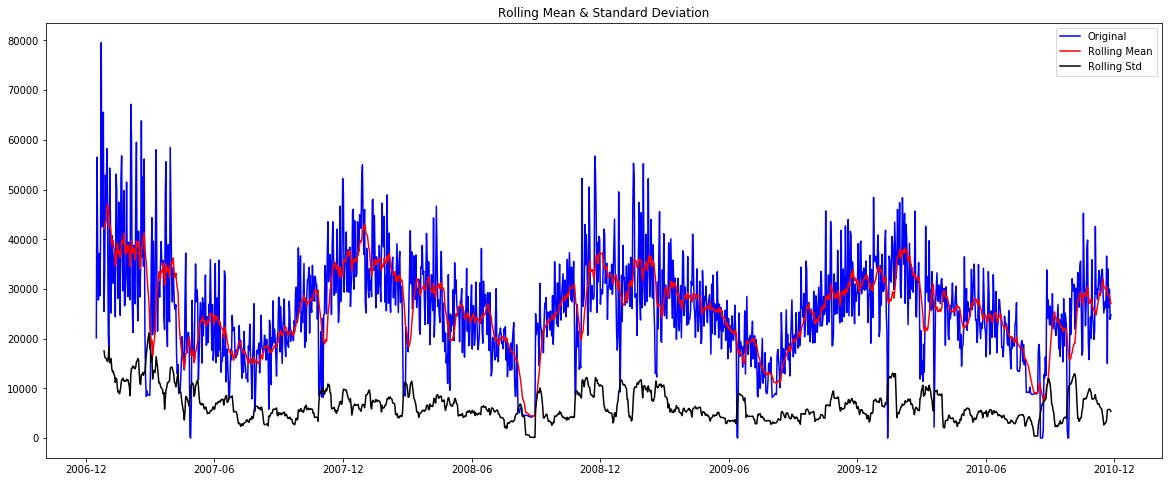

Results of Dickey-Fuller Test:
Test Statistic                   -3.849777
p-value                           0.002437
#Lags Used                       22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (10%)             -2.567856
Critical Value (5%)              -2.863579
dtype: float64


In [104]:
ts_na_filled = ts.fillna(method="pad") #remplissage des données non renseignée
test_stationarity(ts_na_filled) #execution du test adf.

adf qui par sa p-value (.002) permet de dire que la serie est stationnaire; 
admettons encore une fois cette condition puis essayons d'estimer l'ordre p, q, et d pour notre ARIMA(p,d,q) à l'aide de l'autocorellation partielle et de l'autocorellation.

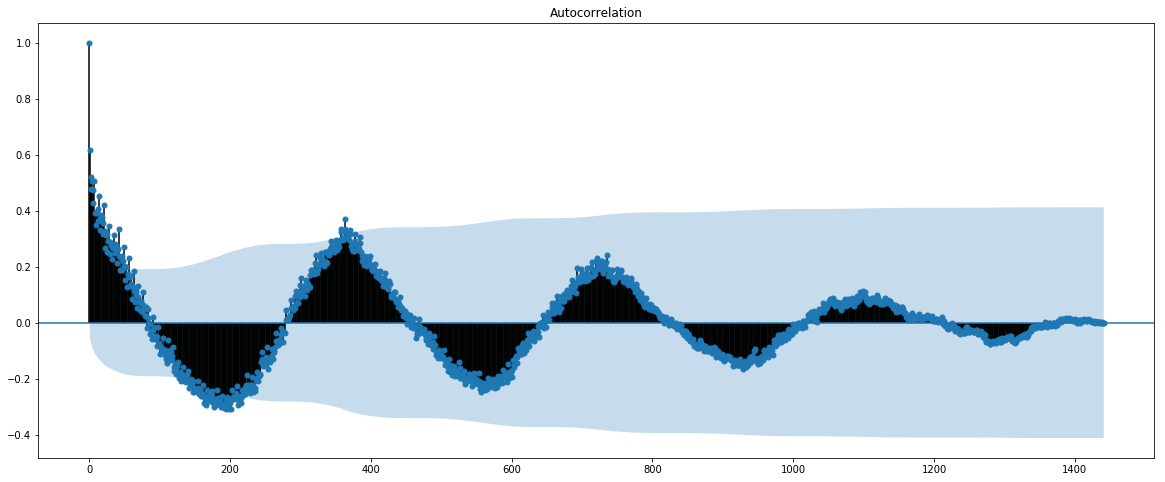

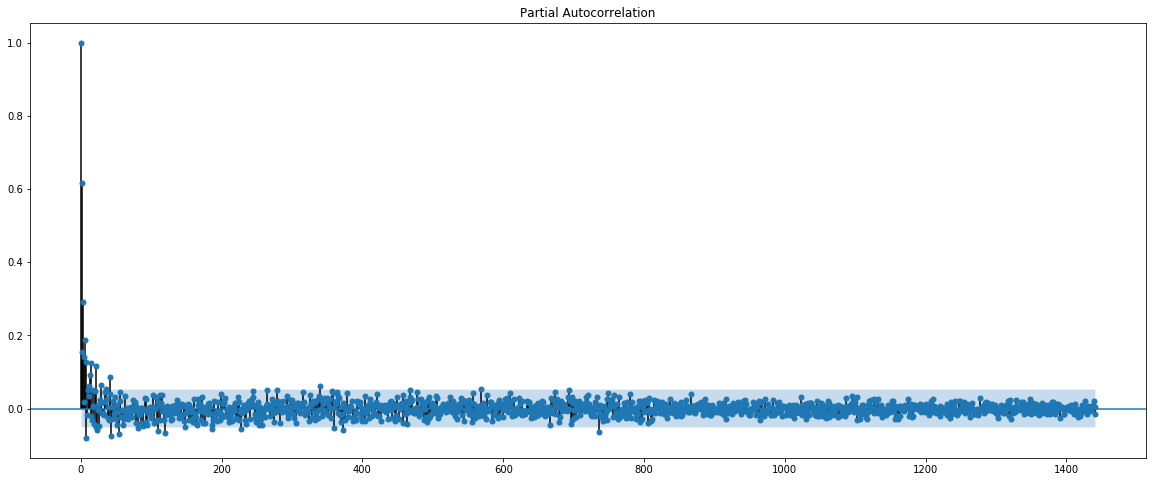

In [100]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

acf_plot = plot_acf(ts)
pacf_plot = plot_pacf(ts)

Très difficile de choisir des ordre de lag significatifs sur ces ACF et PACF pour donner des estimation de "P" et de "D" ...
Nous allons donc proceder a une recherche un peu à l'aveugle en s'appuyant sur un grid de recherche de modele

In [102]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

### recherche du meilleur modele ARIMA

In [46]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(ts_na_filled.values,p_values,d_values,q_values)

ARIMA(0, 0, 0) MSE=76360611.508
ARIMA(0, 0, 1) MSE=55851167.768
ARIMA(0, 0, 2) MSE=51710230.172
ARIMA(0, 1, 0) MSE=56889152.486
ARIMA(0, 1, 1) MSE=40516318.361
ARIMA(0, 1, 2) MSE=39411377.974
ARIMA(0, 2, 0) MSE=155120143.154
ARIMA(0, 2, 1) MSE=57002111.292
ARIMA(1, 0, 0) MSE=46311636.655
ARIMA(1, 0, 1) MSE=39921569.577
ARIMA(1, 0, 2) MSE=38963295.528
ARIMA(1, 1, 0) MSE=49542685.565
ARIMA(1, 1, 1) MSE=39357366.770
ARIMA(1, 1, 2) MSE=39487830.142
ARIMA(1, 2, 0) MSE=103805718.038
ARIMA(2, 0, 0) MSE=44316873.430
ARIMA(2, 0, 1) MSE=38932997.257
ARIMA(2, 0, 2) MSE=39038425.709
ARIMA(2, 1, 0) MSE=44677984.837
ARIMA(2, 1, 1) MSE=39479974.858
ARIMA(2, 1, 2) MSE=39569772.474
ARIMA(2, 2, 0) MSE=81272848.410
ARIMA(4, 0, 0) MSE=40586055.539
ARIMA(4, 0, 1) MSE=39194025.649
ARIMA(4, 0, 2) MSE=39161746.093
ARIMA(4, 1, 0) MSE=42151919.316
ARIMA(4, 1, 1) MSE=39541022.367
ARIMA(4, 1, 2) MSE=39412573.033
ARIMA(6, 0, 0) MSE=39908337.353
ARIMA(6, 0, 1) MSE=39588383.121
ARIMA(6, 0, 2) MSE=39817133.393
ARIMA(

Selon la mesure d'erreur, le meilleur modele choisi est tel que : ARIMA(p,d,q)

p = 10

d = 0

q = 1

### Ajustement et estimation qualité du modele ARIMA (10, 0, 1)

In [105]:
# prepare training dataset
train_size = int(len(ts_na_filled) * 0.66)
train, test = ts_na_filled[0:train_size], ts_na_filled[train_size:]
history = pd.Series()

In [106]:
train = ts_na_filled[0:train_size]

In [107]:
model = ARIMA(train, order=(10,0,1))
model_fit = model.fit(disp=0)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


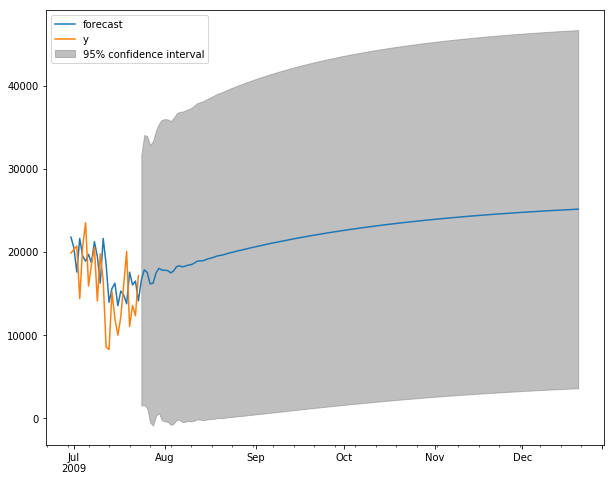

In [110]:
fig, ax = plt.subplots(figsize=(10,8))
fig = model_fit.plot_predict(start='2009-06-30', end='20-12-2009', ax=ax)
legend = ax.legend(loc='upper left')

## 2.2) Conclusion
Je me suis servi des 3 premieres années environs pour pouvoir ajuster ce modele, 
puis on peut observer que sur le forecast au bout de 2 mois l'interval de confiance explose et donne une très mauvaise prediction.

Il aurait fallu pour améliorer mes resultat considerer peut être une fenetre horaire moins importante et normaliser mes données
Ceci dit, l'entrainement de ces petits modeles était malgré tout cronophage, il serait donc peut être plus judicieux de s'appuyer sur les reseaux de neurones qui sont plus adaptés à ces probleme sequentiels, d'autant plus qu'on peut profiter de la puissance de calcul que fournit la carte graphique pour aller plus vite dans l'ajustement de modele deep learning.

# 3) Modele de prediction LSTM 

In [30]:
def getDataAndProcess (path='/Users/anir/Documents/household_power_consumption/household_power_consumption.txt'):
    """
    Fonction qui permet de charger le set de données "household_power_consumption"
    et fait un remplissage des NA values.
    ! attention fonction de chargement de dataset spécifique à celui-ci traité dans ce notebook.
    """
    print("GETTING DATA .... \n")
    df = pd.read_csv(path, sep=';',
                     parse_dates={'dt' : ['Date', 'Time']},
                     infer_datetime_format=True, low_memory=False,
                     na_values=['nan','?'],
                     index_col='dt')
    # remplacaement des NA values par la moyenne 
    for j in range(0,df.shape[1]):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
    
    return df

def sampleDataSet (data,timesteps):
    """
    Fonction qui permet de creer des echantillons test/ train ainsi que de separer les features et les reponses train_X & _y ...
    """
    train = data[:timesteps,:]
    test  = data[timesteps:,]
    
    train_X, train_y = train[:,:-1], train[:,-1]
    test_X, test_y = test[:,:-1], test[:,-1]
    
    return train_X, train_y, test_X, test_y

In [29]:
def shiftDataSet (data, n_in=1, n_out=1, dropnan=True):
    """
    Fonction qui permet de creer via les variables x(t) les nouvelles variables x(t-1) qui vont expliquer l'enchainement de la sequence 
    qu'on cherche à predire, dans notre cas l'energie active consommée par la maison.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
def reshapeDataSetForTimeStep (data):
    """Fonction qui va retourner un tableau à 3 dimension pour inclure la notion timestep dans reseau neuronal"""
    return data.reshape(data.shape[0],1,data.shape[1])

def scaleDataSet (data, _range):
    """Fonction qui a pour but de renvoyer les données normalisées """
    scaler = MinMaxScaler(feature_range = _range)
    return scaler, scaler.fit_transform(data.values) 

In [33]:
def fitLSTM (train_X, train_y, test_X, test_y, layers, dropout, density, epochs, batch_size):
    """Fonction qui va servir à ajuster notre reseau neuronal"""
    model = Sequential()
    model.add(LSTM(layers, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(density))
    model.compile(loss='mean_squared_error', optimizer='adam') #adam for stochastic operations. 
    #we could have choosen tanh, sigmoid, softmax optimizer. depends on the
    #for the loss function we'll use the classic mean_squared_error
    # fit network
    return model, model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                            validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [34]:
def runLSTM (df):
    
    # Resampling
    print("Resampling from minutes to hours ... \n")
    df_resampled = df.resample('h').mean() # nous avons desormais plus que 35000 observations environs
    
    # Normalisation des données
    print("Scaling dataset values ... \n")
    scaler, df_scaled = scaleDataSet(df_resampled, (0,1))  # on normalise 0 and 1.
    
    # Shift data 
    print("shifting data for LSTM... \n")
    df_shifted = shiftDataSet(df_scaled, 1, 1) # df_shifted contient les var(x,t) & var(x,t-1) : x = variable, t = temps
    
    # Isoler les predicteurs 
    colsToDrop = list(range(8,14))
    df_shifted.drop(df_shifted.columns[colsToDrop], axis=1, inplace=True) # on se debarasse de ttes les var(x,t) SAUF var(x=1,t) & var(x, t-1) qui est notre output pour l'algorithme
    print("Sampling dataset into train_X train_y, test_X test_y ...  \n")
    
    # Sampling
    timesteps = 365 * 24  
    train_X, train_y, test_X, test_y = sampleDataSet(df_shifted.values, timesteps) # nous voulons avoir un dataset tel qu'on puisse s'entrainer sur un an 365 jours sachant qu'on a 24 ligne pour un jour on va sampler 365*24 lignes pour le train
    
    # Reshape data to include timesteps
    train_X = reshapeDataSetForTimeStep(train_X)
    test_X = reshapeDataSetForTimeStep(test_X) # qu'on puisse avoir [input,timesteps,features]
    
    # Model fitting 
    
    print("LSTM FITTING .... \n")
    model, history = fitLSTM(train_X, train_y, test_X, test_y, layers=100, dropout=0.2, density=1, epochs=20, batch_size=70)
    
    # Prediction
    pred_normalized = model.predict(test_X)
    
    # On remet le dataset test au format de depart dim(lignes,colonnes)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) 
    test_y = test_y.reshape((test_y.shape[0]), 1)
    
    # de-normalisation de la prediction "y_normalized"
    pred_reverted = scaler.inverse_transform(np.concatenate((pred_normalized,test_X[:,-6:]), axis=1))[:,0] 
    y_reverted = scaler.inverse_transform(np.concatenate((test_y,test_X[:, -6:]), axis=1))[:,0]
    
    """on utilise le scaler declaré precedemment puis grâce à la concatenation des 2 dataframe nous arrivons a inverser la normalisation réalisée au depart
    de-normalisation de la reponse de la prediction et la reponse réelle "test_y" """
    rmse = np.sqrt(mean_squared_error(y_reverted, pred_reverted))
    print('Le taux d\'erreur réalisé sur le dataset en RMSE: %.3f' % rmse)
    
    return model, history, pred_reverted, y_reverted

## 3.2) Demarche : 

   En pretant attention à la fonction "runLSTM" ou je fais la majorité des operations, nous allons proceder ainsi de la sorte pour créer notre reseau de neurones LSTM.

* __Resampling__ : Pour les besoins d'une demonstration rapide nous allons simplement prendre la moyenne de toutes les variables pour chaque heure donnée. ainsi nous reduisons considerablement le nombre d'entrées pour une convergence plus rapide de l'algorithme 

* __Normalisation des données__ : normalisation du dataset entre 1 et 0

* __Shifting data __ : pour tout x dans {"global_active_energy"...}, cette etape va renvoyer un dataset qui contient les var(x,t) & et toutes les variables decalées d'1 index __var(x,t-1)__ , t = temps

* __Isoler les predicteurs & la cible__ : on veut dans le cadre de la création de notre LSTM, utiliser comme predicteurs les __var(x,t-1)__ et predire la __var(x="global_active_energy",t)__

* __Sampling__ : Nous allons dans cette etape diviser notre set de train et de test

* __Reshape data__ : Nous procedons a un dernier "reshape" de notre data pour inclure une 3eme dimension dans nos données, comme le requiert le modele LSTM pour prendre en compte le "timestep" ou encore la notion sequentielle du probleme.

* __Model fitting__ : Nous passons les sets de données crées durant les etapes décrit précedemment, ainsi que des parametres pour notre reseau de neurones 

* __De-normalisation de la prediction__ : Une derniere etape consiste à inverser le mecanisme de normalisation de données, qui part d'une matrice dont les valeurs sont comprise entre 0 et 1 et la transformer au minmax detecter dans la matrice test de depart.  

## 3.3) Neural Net architecture

#### 1) Un LSTM avec 100 couches 
#### 3) un dropout 20%
#### 4) 1 neuron in the output layer for predicting Global_active_power.  1 seul neuron dans la couche de sortie pour predire l'energie active
#### 5) Chaque input sera composé d'une periode (timestep = 1) et aura 7 variables

#### 6) mean squared error (MAE) en tant que loss function, et l'optimizer Adam . (on aurait pu choisir gradiant descent ou autre..)

#### 7) Le model sera ajuster pour 20  "epochs" avec un batch de 70.

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense


In [10]:
data = getDataAndProcess()

GETTING DATA .... 



In [35]:
model, history, pred, y = runLSTM(data)

Resampling from minutes to hours ... 

Scaling dataset values ... 

shifting data for LSTM... 

Sampling dataset into train_X train_y, test_X test_y ...  

LSTM FITTING .... 

Train on 8760 samples, validate on 25828 samples
Epoch 1/20
 - 3s - loss: 0.0186 - val_loss: 0.0119
Epoch 2/20
 - 1s - loss: 0.0125 - val_loss: 0.0105
Epoch 3/20
 - 1s - loss: 0.0113 - val_loss: 0.0097
Epoch 4/20
 - 2s - loss: 0.0108 - val_loss: 0.0092
Epoch 5/20
 - 1s - loss: 0.0106 - val_loss: 0.0092
Epoch 6/20
 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 7/20
 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 8/20
 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 9/20
 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 10/20
 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 11/20
 - 1s - loss: 0.0104 - val_loss: 0.0094
Epoch 12/20
 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 13/20
 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 14/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 15/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoc

### Representation de convergence de l'apprentissage du reseau

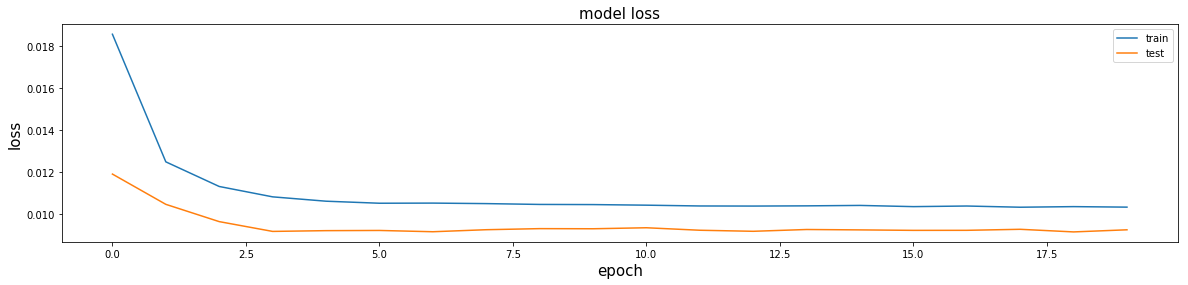

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',size=15)
plt.ylabel('loss', size=15)
plt.xlabel('epoch', size=15)
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Representation de la prediction vs réel sur 500 timesteps 

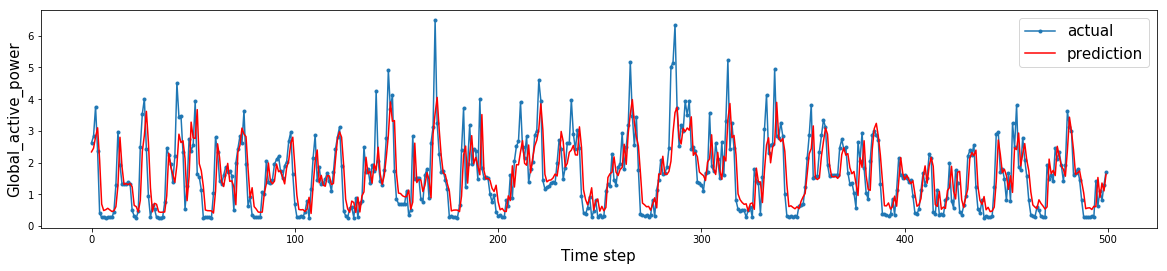

In [40]:
ts = [x for x in range(500)]
plt.plot(ts, y[:500], marker='.', label="actual")
plt.plot(ts, pred[:500], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## 3.3) Conclusion

Les reseaux de neurones sont très utilisés dans le cadre de la prediction de processus stochastique, de plus le choix du reseau neuronal LSTM se justifie par la nécessité d'avoir une mémoire de prediction à "court terme" ainsi qu'a "long terme" pour mieux definir contexte dans lequel le reseau devra repondre.

En comparant les resultats obtenus, il est clair qu'il est beaucoup plus facile de s'appuyer sur cette methode afin de resoudre un problème sequentiel plutôt que sur les time-series. 

Pour preuve, les parametres pour le reseau neuronal ont été choisis arbitrairement (epoch, layers, density, et batch_size). Malgré cela, on obtient un RMSE de 0.62 contrairement a un RMSE 1962017 pour notre meilleur modele time series. De plus la prediction des time-series ajustée pour ce problème predit des valeurs avec un interval de confiance beaucoup trop elevé.

Pour aboutir à de bon resultats en s'appuyant sur les time series Il est nécessaire d'avoir une très bonne connaissance des outils a disposition (differenciation, desaisonnalisation, test de stationarité, estimation des ordres etc...). 

Tandis que notre LSTM peut être simplement améliorer en jouant sur les parametres de mémoire (dropout), ou du nombre de couche pour former le reseau (layers).
Mais en plus, on considère toutes les variables dans ce modele tandis que pour les time-series j'ai simplement du m'appuyer sur le temps ( serie univariée) 

A l'aide d'un reseau neuronal, on peut s'approcher plus rapidement de la reponse et on sera plus précis!.